In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from scipy.sparse import load_npz, save_npz, csr_matrix

In [2]:
rating_matrix_sparse = load_npz('rating_matrix_sparse.npz')
row_indices = rating_matrix_sparse.row
col_indices = rating_matrix_sparse.col
data = rating_matrix_sparse.data

entries = np.vstack((row_indices, col_indices, data)).T


In [4]:
from scipy.sparse import coo_matrix, save_npz, load_npz
import numpy as np
from sklearn.model_selection import train_test_split

# Load the sparse rating matrix
rating_matrix_sparse = load_npz('rating_matrix_sparse.npz')
row_indices = rating_matrix_sparse.row
col_indices = rating_matrix_sparse.col
data = rating_matrix_sparse.data

entries = np.vstack((row_indices, col_indices, data)).T

# Filter users with at least 15 entries
user_row_counts = np.bincount(row_indices)
valid_users = np.where(user_row_counts >= 15)[0]

# Filter entries to include only valid users
filtered_entries = entries[np.isin(entries[:, 0], valid_users)]

# Shuffle the filtered entries
np.random.seed(42)  # Ensure reproducibility
np.random.shuffle(filtered_entries)

# Select exactly 5000 entries for the test set
test_entries = filtered_entries[:5000]

# Create a mask for the train set (entries not in the test set)
test_indices_set = set(map(tuple, test_entries))
train_mask = np.array([tuple(entry) not in test_indices_set for entry in entries])
train_entries = entries[train_mask]

# Create train and test matrices
num_users, num_games = rating_matrix_sparse.shape
train_matrix = coo_matrix((train_entries[:, 2], (train_entries[:, 0], train_entries[:, 1])),
                          shape=(num_users, num_games))
test_matrix = coo_matrix((test_entries[:, 2], (test_entries[:, 0], test_entries[:, 1])),
                         shape=(num_users, num_games))

# Save the matrices
save_npz('train_matrix.npz', train_matrix)
save_npz('test_matrix.npz', test_matrix)

print("Files train_matrix.npz and test_matrix.npz have been created.")


Files train_matrix.npz and test_matrix.npz have been created.


In [5]:
from scipy.sparse import load_npz, save_npz, coo_matrix
import numpy as np

# Load the train and test matrices
train_matrix = load_npz('train_matrix.npz')
test_matrix = load_npz('test_matrix.npz')

# Convert test matrix to COO format for easy manipulation
if not isinstance(test_matrix, coo_matrix):
    test_matrix = coo_matrix(test_matrix)

# Extract row, column, and data from test matrix
test_row = test_matrix.row
test_col = test_matrix.col
test_data = test_matrix.data

# Group test entries by user_id
test_entries_by_user = {}
for row, col, data in zip(test_row, test_col, test_data):
    if row not in test_entries_by_user:
        test_entries_by_user[row] = []
    test_entries_by_user[row].append((col, data))

# Split test data for each user into 60% and 40%
train_and_test_rows = []
train_and_test_cols = []
train_and_test_data = []

rest_test_rows = []
rest_test_cols = []
rest_test_data = []

for user, entries in test_entries_by_user.items():
    entries = np.array(entries)  # Convert to numpy array
    num_entries = len(entries)
    split_idx = int(num_entries * 0.6)  # Calculate 60% split point

    # Shuffle entries for randomness
    np.random.seed(42)  # Ensure reproducibility
    np.random.shuffle(entries)

    # 60% of entries go to train_and_test
    for col, data in entries[:split_idx]:
        train_and_test_rows.append(user)
        train_and_test_cols.append(col)
        train_and_test_data.append(data)

    # 40% of entries go to rest_test
    for col, data in entries[split_idx:]:
        rest_test_rows.append(user)
        rest_test_cols.append(col)
        rest_test_data.append(data)

# Combine train_matrix with 60% of test_matrix to create train_and_test
train_and_test_matrix = coo_matrix((
    np.hstack([train_matrix.data, train_and_test_data]),
    (
        np.hstack([train_matrix.row, train_and_test_rows]),
        np.hstack([train_matrix.col, train_and_test_cols])
    )
), shape=train_matrix.shape)

# Create rest_test matrix
rest_test_matrix = coo_matrix((
    rest_test_data,
    (rest_test_rows, rest_test_cols)
), shape=test_matrix.shape)

# Save the new matrices
save_npz('train_and_test.npz', train_and_test_matrix)
save_npz('rest_test.npz', rest_test_matrix)

print("Files train_and_test.npz and rest_test.npz have been created.")


Files train_and_test.npz and rest_test.npz have been created.


In [7]:
import matplotlib.pyplot as plt
recommendations = pd.read_csv('./recommendations.csv')

user_recommendations = recommendations.groupby('user_id')['review_id'].count()
app_recommendations = recommendations.groupby('app_id')['review_id'].count()

avg_user_recommendations = user_recommendations.mean()
avg_app_recommendations = app_recommendations.mean()

print(f"Średnia liczba rekomendacji na użytkownika: {avg_user_recommendations:.2f}")
print(f"Średnia liczba rekomendacji na grę: {avg_app_recommendations:.2f}")

Średnia liczba rekomendacji na użytkownika: 2.98
Średnia liczba rekomendacji na grę: 1497.28


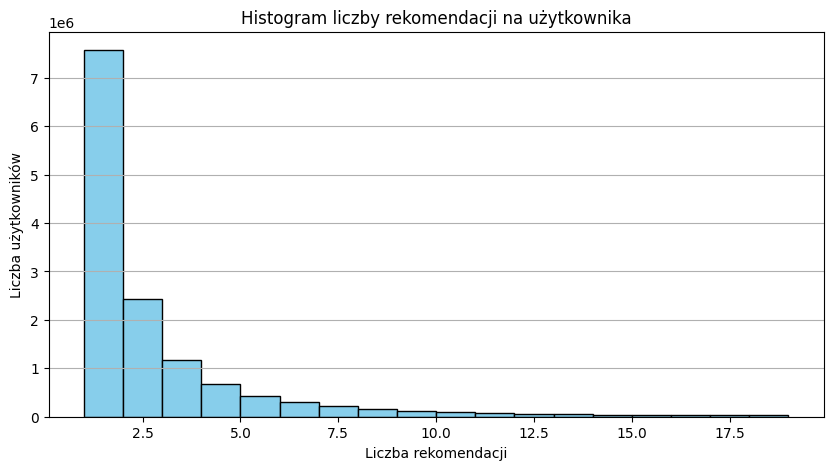

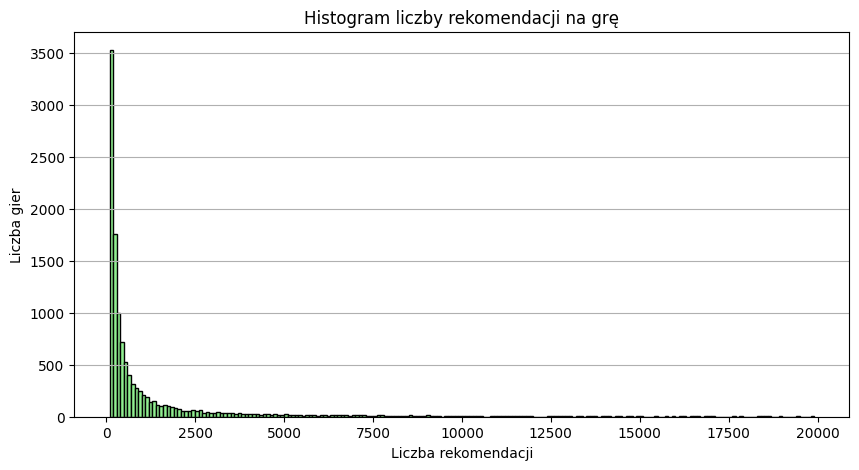

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(user_recommendations, bins=range(1, 20, 1), color='skyblue', edgecolor='black')
plt.title('Histogram liczby rekomendacji na użytkownika')
plt.xlabel('Liczba rekomendacji')
plt.ylabel('Liczba użytkowników')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(app_recommendations, bins=range(100, 20000, 100), color='lightgreen', edgecolor='black')
plt.title('Histogram liczby rekomendacji na grę')
plt.xlabel('Liczba rekomendacji')
plt.ylabel('Liczba gier')
plt.grid(axis='y')
plt.show()

In [ ]:
import pandas as pd

# 1. Wczytaj dane z pliku recommendations.csv
df = pd.read_csv('cleora/recommendations.csv')

# 2. Stwórz słownik, gdzie kluczem jest app_id, a wartością liczba wierszy dla tego app_id
app_recommendations_count = df['app_id'].value_counts().to_dict()


# 3. Stwórz nowy DataFrame, pomijając app_id, które mają mniej niż 15 wystąpień
filtered_df = df[df['app_id'].apply(lambda x: app_recommendations_count[x] >= 15)]

# 4. Zapisz nowy DataFrame do pliku
filtered_df.to_csv('filtered_recommendations.csv', index=False)

print(f"Zapisano przefiltrowany plik z {len(filtered_df)} wierszami.")

Zapisano przefiltrowany plik z 41073462 wierszami.
